# Lesson 3: Customized Physics Processes

In this lesson, you will learn how to setup and configure the morphing for use with your own physics process. 

![anything you like!](https://media.giphy.com/media/B5pUPWy5c5KMM/giphy.gif "morph that")

For the time being, we are still using the same scenario as in the previous lesson, but this time, we will not use the pre-made RooHCvbfWWMorphFunc! However, we will focus on processes with only two vertices for now, one of which we will label as the "production vertex", the other as the "decay vertex". 

Expanding the number of morphing parameters

## Setup files and samples

These are set up as before. The identifier is just a hook to specify the name in the file structure.

In [1]:
gSystem->Load("libRooLagrangianMorphing");


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
!wget https://www.nikhef.nl/~cburgard/downloads/RooLagrangianMorphingTutorial/inputs/vbfhwwlvlv_3d.root -nc

File ‘vbfhwwlvlv_3d.root’ already there; not retrieving.



In [3]:
std::string identifier("vbfWW"); // avaliable: ggfWW, vbfWW, vbfZZ, ggfZZ, vbfMuMu
std::string infilename("vbfhwwlvlv_3d.root"); // give the input file name here
std::string observable("twoSelJets/dphijj"); // name of the observable to be used (histogram name)

Once again all 15 VBF parameters are considered.

In [4]:
std::vector<std::string> samplelist = {"kAwwkHwwkSM0","kAwwkHwwkSM1","kAwwkHwwkSM10","kAwwkHwwkSM11","kAwwkHwwkSM12","kAwwkHwwkSM13","kAwwkHwwkSM2","kAwwkHwwkSM3","kAwwkHwwkSM4","kAwwkHwwkSM5","kAwwkHwwkSM6","kAwwkHwwkSM7","kAwwkHwwkSM8","kAwwkHwwkSM9","kSM0"};
// these are the validation samples: "v0","v1","v2","v3","v4","v5","v6","v7","v8","v9"

push all the input samples in a RooArgList

In [5]:
RooArgList inputs;
for(auto const& sample: samplelist) {
    RooStringVar* v = new RooStringVar(sample.c_str(),sample.c_str(),sample.c_str());
    inputs.add(*v);
}

## setup morphing function by hand

The [RooLagrangianMorphing](https://gitlab.cern.ch/cburgard/RooLagrangianMorphing/tree/master) class provides a constructor to which you can pass two instances of RooArgSet that contains the couplings appearing in the individual vertices. In principle, these couplings can be any RooFit class that represents an (either dependant or independent) real number.

In order to be compliant with the [Higgs Characterization model](https://arxiv.org/abs/1306.6464), which we will be using throughout this tutorial, we will create these couplings as functions of the input parameters of the model, but this is not a restriction of the implementation - rather a choice to be made depending on the model you are using. 

* Decide which input parameters you need and create an instances of RooRealVar for each of them. In the case at hand, you will need "Lambda" and "cosa" (which will be constant and set to the values of Lambda=1000 and cosa=1./sqrt(2) respectively) as well as kSM, kHww and kAww.
* Create the couplings as instances of RooFormulaVar as dependants of your input parameters. For this example of CP measurements of VBF HWW, the following list might help:

  * gSM: $\cos\alpha\cdot\kappa_\mathrm{SM}$
  * gHww: $\cos\alpha\cdot\kappa_{Hww}/\Lambda$
  * gAww: $\sqrt{1-(\cos\alpha)^2}\cdot\kappa_{Aww}/\Lambda$ 

* Create two RooArgSets, one for each vertex.
* Add the couplings to each vertex at which they appear.
* Call a constructor of RooLagrangianMorphFunc, passing over the two lists that you have created:

    ```ROOT.RooLagrangianMorphFunc(name,title,infilename,observable,prodCouplings,decCouplings,inputs)```

In [6]:
RooRealVar* cosa   = new RooRealVar("cosa","cosa",1./sqrt(2));
RooRealVar* lambda = new RooRealVar("Lambda","Lambda",1000.);
RooRealVar* kSM    = new RooRealVar("kSM","kSM",1.,0.,2.);
RooRealVar* kHww   = new RooRealVar("kHww","kHww",0.,-20.,20.);
RooRealVar* kAww   = new RooRealVar("kAww","kAww",0.,-20.,20.);

let's check that this is the same as the diagram before proceeding:<img src="images/VBFHWW-EFT.png" alt="wiggle it some more!" style="width: 600px;"/>

If it works then let's define the couplings at each vertex

In [7]:
RooArgSet prodCouplings("vbf");
RooArgSet decCouplings("hww")

(RooArgSet &) Name: hww Title: Set of RooAbsArg objects


here `vbf` and `hww` are just names. We must add the parameters by hand.

In [8]:
prodCouplings.add(*(new RooFormulaVar("_gSM"  ,"cosa*kSM",                        RooArgList(*cosa,*kSM))));
prodCouplings.add(*(new RooFormulaVar("_gHww" ,"cosa*kHww/Lambda",                RooArgList(*cosa,*kHww,*lambda))));
prodCouplings.add(*(new RooFormulaVar("_gAww" ,"sqrt(1-(cosa*cosa))*kAww/Lambda", RooArgList(*cosa,*kAww,*lambda))));
decCouplings.add (*(new RooFormulaVar("_gSM"  ,"cosa*kSM",                        RooArgList(*cosa,*kSM))));
decCouplings.add (*(new RooFormulaVar("_gHww" ,"cosa*kHww/Lambda",                RooArgList(*cosa,*kHww,*lambda))));
decCouplings.add (*(new RooFormulaVar("_gAww" ,"sqrt(1-(cosa*cosa))*kAww/Lambda", RooArgList(*cosa,*kAww,*lambda))));

Then we make the morphing function. This time without a box!
![morph](https://media.giphy.com/media/uPCq54xGTA8ve/giphy.gif "what's in the box")

In [9]:
RooLagrangianMorphFunc * morphfunc = new RooLagrangianMorphFunc("morphfunc","morphfunc",infilename.c_str(),observable.c_str(),prodCouplings,decCouplings,inputs);

RooLagrangianMorphBase: a RooFit class for morphing physics distributions between configurations. authors:
   Lydia Brenner   (lbrenner@cern.ch)
   Carsten Burgard (cburgard@cern.ch)
   Katharina Ecker (kecker@cern.ch)
   Adam Kaluza     (akaluza@cern.ch)
please feel free to contact with questions and suggestions.


morph to the validation sample v1

In [10]:
std::string validationsample("v1");
morphfunc->setParameters(validationsample.c_str());
TH1* morphing = morphfunc->createTH1("morphing");

## Read The Validation Histogram

We now retrieve the corresponding histogram of the validation sample from the same input file. 

In [11]:
TFile* file = TFile::Open(infilename.c_str(),"READ");
TFolder* folder = 0;
file->GetObject(validationsample.c_str(),folder);
TH1* validation = dynamic_cast<TH1*>(folder->FindObject(observable.c_str()));
validation->SetDirectory(NULL);
validation->SetTitle(validationsample.c_str());
file->Close();

## Print the pretty plots!
we use the canvas created above and add legend in order to plot both histograms - the one obtained from the validation sample and the morphing prediction for the same parameter set - for comparison.

Here I use the rootnotes macro to provide inline plots. On newer releases this isn't necesarry, but then the Function isn't available... 

Here I use the rootnotes macro to provide inline plots on newer releases this isn't necesarry.

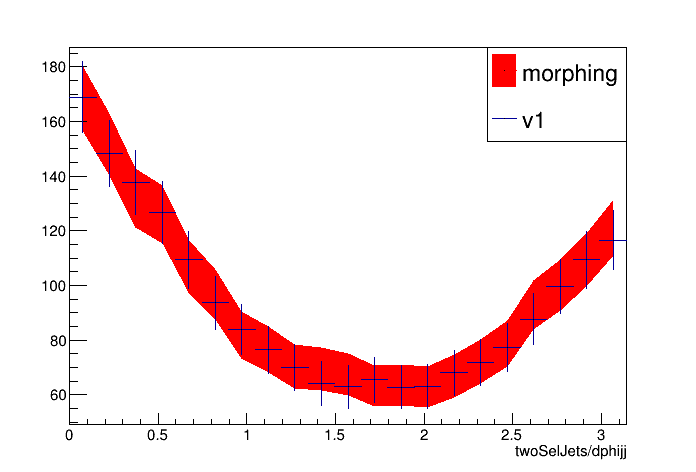

In [12]:
TCanvas* plot = new TCanvas("plot");
plot->cd();
gStyle->SetOptStat(0);
gStyle->SetOptTitle(0);
morphing->GetXaxis()->SetTitle(observable.c_str());
morphing->SetLineColor(kRed);
morphing->SetFillColor(kRed);
morphing->Draw("E3");
validation->Draw("SAME");
TLegend* leg = new TLegend(0.7,0.7,0.9,0.9);
leg->AddEntry(morphing);
leg->AddEntry(validation);
leg->Draw();
plot->Draw();

![prettyfull](https://media.giphy.com/media/it6W8D4FfvaPC/giphy.gif "So pretty, very wow")

## Playground
* As you have now seen, the model includes additional parameters Lambda and cosa that we have not been using so far. What happens when you change their values? How does the resulting distribution change? Are the results still physical? Why should they (not)?
* Have a look at the header file of the RooLagrangianMorphFunc (which is located in here /afs/cern.ch/user/c/cburgard/public/RooEFTMorphFuncTutorial20160422/RooEFTMorphFunc/default/inc/RooStats/RooEFTMorphFunc.h) and search for the implementations of the pre-made classes you have been using earlier. Does this look any different from what you did? 